# 7 Instruction fine-tuning

In questa sezione alleneremo il modello a seguire istruzioni umane. Questo processo e alla base della creazione di chatbot e assistenti personali. Questa specifica tipologia di task prende il nome di *conversational tasks*.

Per l'allenamento utilizzeremo un dataset giocattolo, molti altri dataset di istruzioni possono essere trovati online.

## 7\.1 Preparazione del dataset

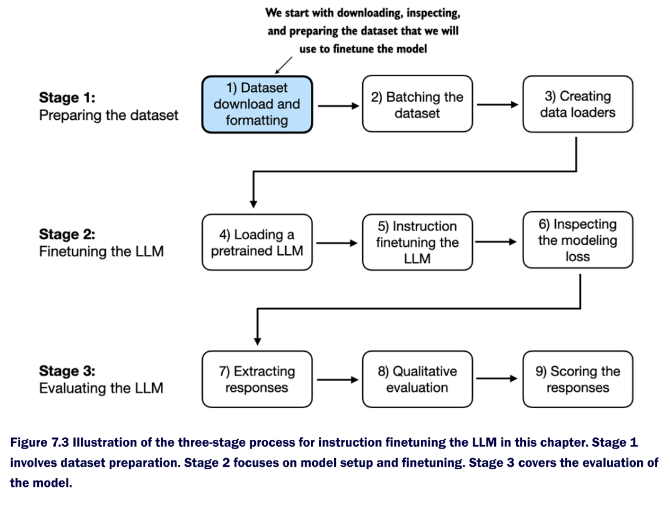

In [1]:
# download del dataset
import json
import os
import urllib

def download_and_load_file(file_path, url):
  if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
      text_data = response.read().decode("utf-8")
    with open(file_path, 'w', encoding = 'utf-8') as file:
      file.write(text_data)
  else:
    with open(file_path, 'r', encoding='utf-8') as file:
      text_data = file.read()
  with open(file_path, 'r') as file:
    data = json.load(file)
  return data

file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


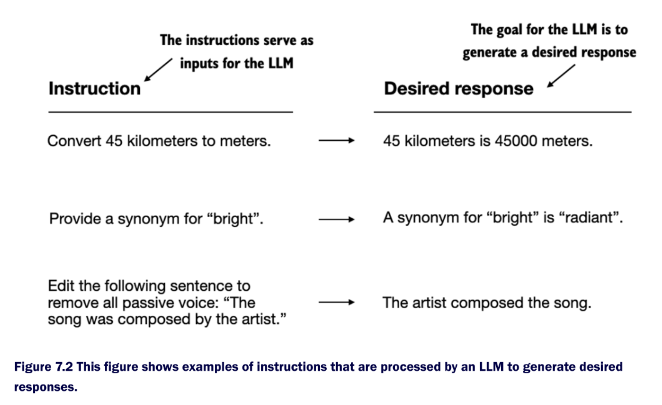

In [2]:
output_length = 10
print('Class of each instance in the data set: \n', data[0].__class__)
print('Keys of each instance: \n', data[0].keys())
print('Values of each instance: \n', data[0].values())

Class of each instance in the data set: 
 <class 'dict'>
Keys of each instance: 
 dict_keys(['instruction', 'input', 'output'])
Values of each instance: 
 dict_values(['Evaluate the following phrase by transforming it into the spelling given.', 'freind --> friend', 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'])


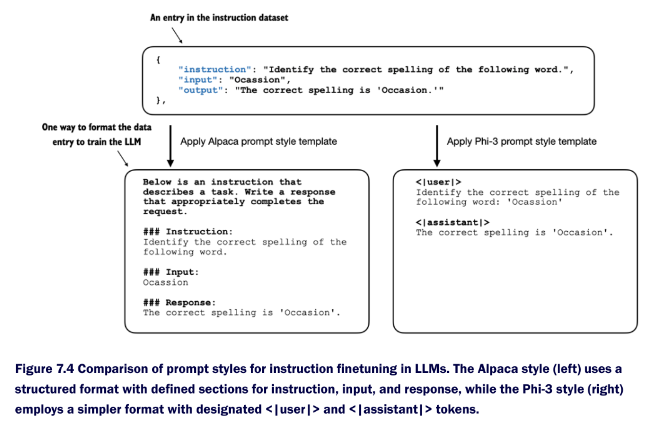

In [3]:
example_length = 3
print('Example instruction: \n', [data[i]['instruction'] for i in range(example_length)])
print('Example input: \n', [data[i]['input'] for i in range(example_length)])
print('Example output: \n', [data[i]['output'] for i in range(example_length)])

Example instruction: 
 ['Evaluate the following phrase by transforming it into the spelling given.', 'Edit the following sentence for grammar.', 'Convert 45 kilometers to meters.']
Example input: 
 ['freind --> friend', 'He go to the park every day.', '']
Example output: 
 ['The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".', 'He goes to the park every day.', '45 kilometers is 45000 meters.']


### 7\.1\.1 Formattazione del prompt

E possibile scegliere la modalita con la quale si decide di definire il prompt di allenamento. A seconda di questa sceta otteniamo comportamenti di risposta diversi nel modello.

In [4]:
# alpaca format_style
def format_input(entry):
  instruction_text = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appriopriately completes that request."
      f"\n\n### Instruction:\n{entry['instruction']}"
  )
  input_text = (
      f"\n\n### Input:\n{entry['input']}"
  )
  return instruction_text + input_text

In [5]:
# alpaca format_style
def format_input_phi3(entry):
  instruction_text = (
      f'<|user|>\n'
      f'{entry['instruction']}'
  )
  input_text = (
      f"{entry['input']}"
  )
  return instruction_text + input_text

model_input = format_input_phi3(data[60])
desired_response = f"\n<|assistant|>\n{data[60]['output']}"
print(model_input + desired_response)

<|user|>
Provide a synonym for 'fast'.
<|assistant|>
A synonym for 'fast' is 'quick'.


In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appriopriately completes that request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appriopriately completes that request.

### Instruction:
What is an antonym of 'complicated'?

### Input:


### Response:
An antonym of 'complicated' is 'simple'.


### 7\.1\.2 Suddivisione del dataset in batch

In [8]:
# suddivisione del dataset
train_portion = int(len(data)*0.85)
test_portion = int(len(data)*0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length: ", len(train_data))
print("Validation set length: ", len(val_data))
print("Test set length: ", len(test_data))

Training set length:  935
Validation set length:  55
Test set length:  110


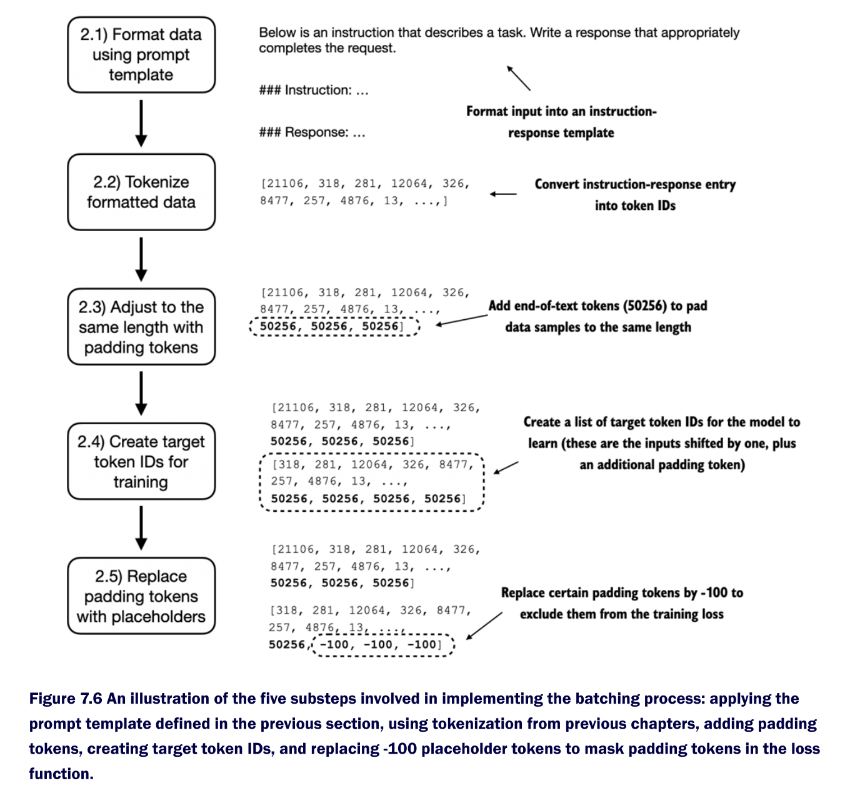

In [9]:
# passo 1 e 2
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.encoded_texts = []
    for entry in data:
      # formattazione dell'input
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      # tokenizzazione dell'input
      self.encoded_texts.append(
          tokenizer.encode(full_text)
      )

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)

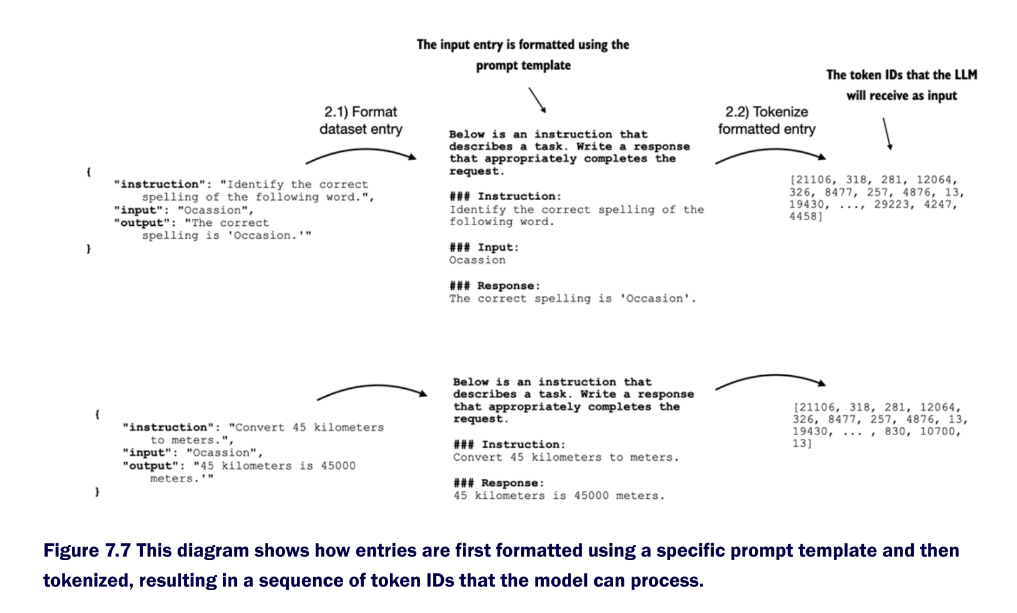

In [10]:
# passi 3,4,5
def custom_collate_fn(
    batch,
    pad_token_id = 50256, # <|endoftext|>
    ignore_index = -100,
    allowed_max_length = None,
    device = 'cpu'):

  # la lunghezza massima delle serie in un batch dipende dalla lunghezza della serie piu lunga di quel batch
  batch_max_length = max(len(item)+1 for item in batch)
  inputs_list, targets_list = [],[]

  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

    # padding delle sequenze troppo corte
    padded = (
        new_item + [pad_token_id]*(batch_max_length-len(new_item))
    )

    # creazione tramite shift di una posizione della sequenza di output
    inputs = torch.tensor(padded[:-1]) # Changed from padded[:,-1]
    targets = torch.tensor(padded[1:]) # Changed from padded[:,1:]

    # masking dei padding non necessari
    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      # maschera tutti i padding tranne il primo <|endoftext|>
      targets[indices[1:]] = ignore_index

    # troncamento input e target nel caso in cui il modello abbia un limite sulla lunghezza delle sequenze in input
    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_list.append(inputs)
    targets_list.append(targets)

  inputs_tensor = torch.stack(inputs_list).to(device)
  targets_tensor = torch.stack(targets_list).to(device)
  return inputs_tensor, targets_tensor

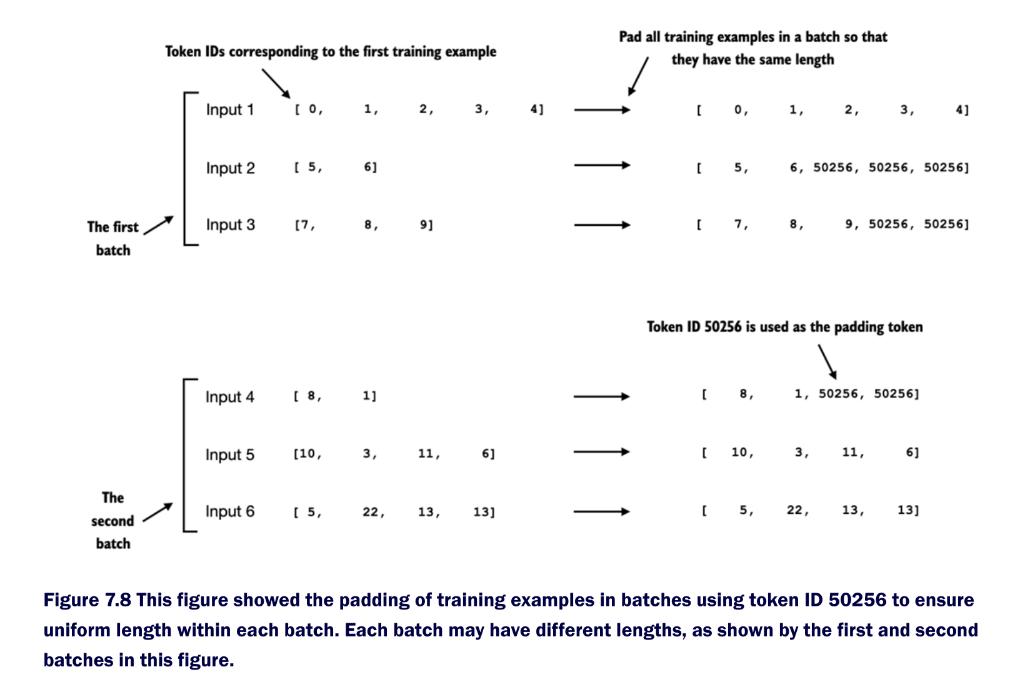

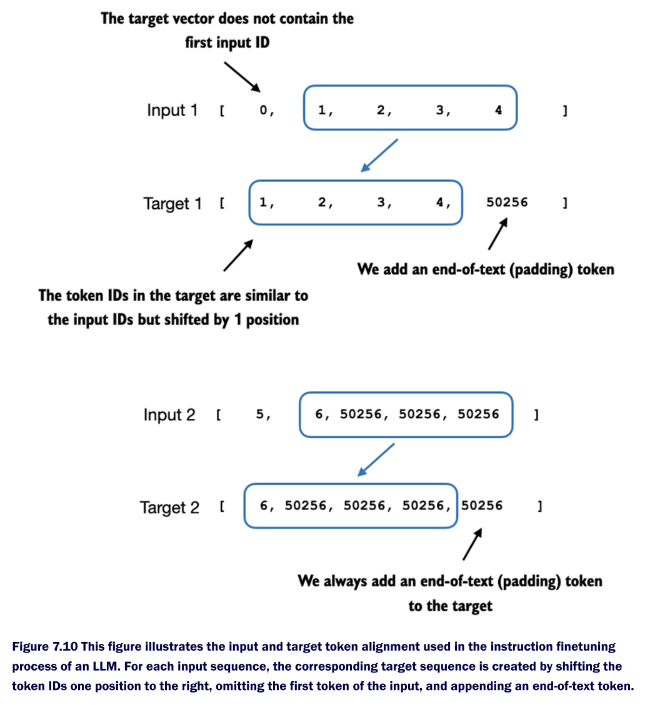

Quando mascheriamo i padding token non necessari, li leviamo tutti tranne il primo. Infatti solamente il primo token di padding e necessatio per far comprendere al modello quando concludere la risposta.

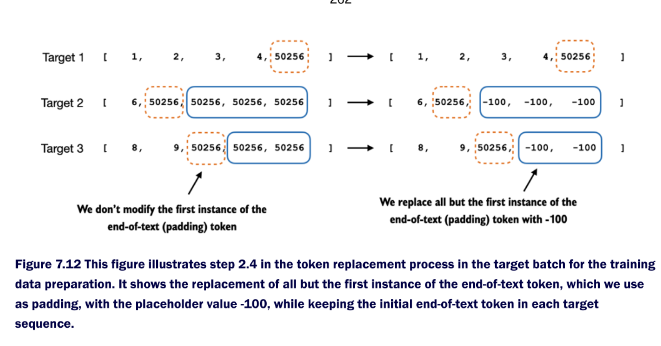

In [11]:
# esempio
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
inputs_1,
inputs_2,
inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])




---



#### Il Ruolo del Token -100 nel Calcolo della Loss
Il *masking* nel contesto delle funzioni di loss, e in particolare l'uso del token **-100**, è una tecnica fondamentale per addestrare i modelli di linguaggio in modo efficiente ed efficace.

#### Il Contesto: Padding e Cross-Entropy
La funzione di loss standard per la generazione di testo è la **Cross-Entropy**. Questa misura la discrepanza tra la distribuzione di probabilità predetta dal modello e il token *target* (obiettivo) corretto.

Per addestrare i modelli in batch, le sequenze di input e target (etichette) devono avere la stessa lunghezza. Poiché le frasi hanno lunghezze variabili, quelle più corte vengono estese tramite *padding* (riempimento) per raggiungere la lunghezza massima nel batch.

#### La Soluzione: Il Valore Speciale -100
Sorge un problema: il modello non deve essere addestrato a predire i token di padding, poiché sono artefatti introdotti per motivi tecnici e non fanno parte del linguaggio reale.

Qui interviene il valore **-100**. La scelta di questo specifico intero non è casuale. Le implementazioni standard della `CrossEntropyLoss` (ad esempio, in PyTorch) sono progettate per **ignorare** nel calcolo della loss qualsiasi posizione in cui l'etichetta (il token target) è impostata a -100.

Di conseguenza, utilizzando -100 come valore per i token di padding nel batch *target*, ci assicuriamo che la loss venga calcolata **esclusivamente** sui token effettivi della sequenza.

#### Applicazione Avanzata: Masking delle Istruzioni
Questa tecnica, nota come *instruction masking*, offre un controllo granulare sull'addestramento. Non si limita solo al padding.

Se l'obiettivo è addestrare il modello a generare una risposta (output) a partire da un'istruzione (input), è possibile applicare il masking anche all'istruzione. Impostando i token target corrispondenti all'istruzione di input a -100, la loss verrà calcolata **unicamente** sui token della risposta che vogliamo il modello generi.

In sintesi, il valore -100 agisce come un "interruttore" per la funzione di loss, permettendo di focalizzare l'addestramento solo sulle parti della sequenza che sono rilevanti per l'obiettivo specifico.

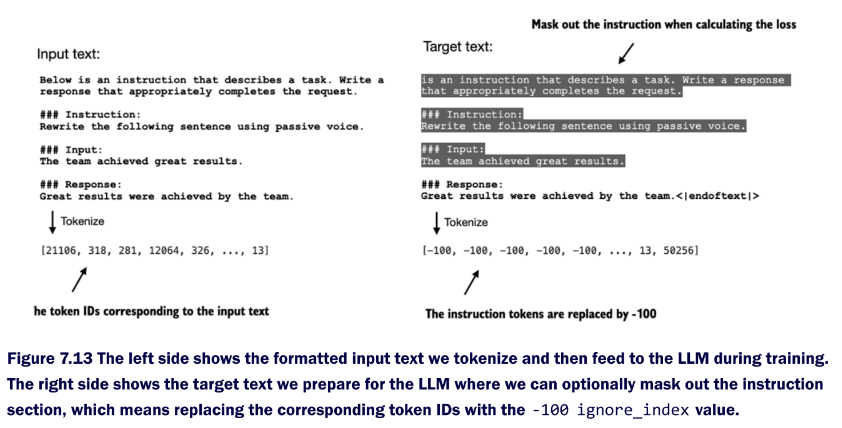

### 7\.1\.3 Implementazione dell'instruction masking

In [12]:
# passo 1 e 2
import torch
from torch.utils.data import Dataset

class InstructionDataset_InstructionMasking(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.encoded_texts_dict = []

    for entry in data:
      # formattazione dell'input
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      # tokenizzazione dell'input
      full_text = {'instruction':tokenizer.encode(instruction_plus_input), 'output': tokenizer.encode(response_text)}

      self.encoded_texts_dict.append(
          full_text
      )

  def __getitem__(self, index):
    return self.encoded_texts_dict[index]

  def __len__(self):
    return len(self.data)

In [13]:
# passi 3,4,5
def custom_collate_fn_InstructionMasking(
    batch,
    pad_token_id = 50256, # <|endoftext|>
    ignore_index = -100,
    allowed_max_length = None,
    device = 'cpu'):

  # the maximum length of the sequences in a batch depends on the length of the longest sequence in that batch
  batch_max_length = 0
  for item in batch:
      full_item = item['instruction'] + item['output']
      if len(full_item) + 1 > batch_max_length:
          batch_max_length = len(full_item) + 1


  inputs_list, targets_list = [],[]

  for item in batch:
    full_item = item['instruction'] + item['output']
    new_item = full_item.copy()
    new_item += [pad_token_id]

    # padding of short sequences
    padded = (
        new_item + [pad_token_id]*(batch_max_length-len(new_item))
    )

    # creation by shifting one position of the output sequence
    inputs = torch.tensor(padded[:-1])
    targets = torch.tensor(padded[1:])

    # masking of unnecessary padding
    mask1 = targets == pad_token_id
    indices = torch.nonzero(mask1).squeeze()
    if indices.numel() > 0: # Check if there are any padding tokens
        if indices.numel() > 1:
          # mask all padding except the first <|endoftext|>
          targets[indices[1:]] = ignore_index
        # The first padding token is kept for the target

    # masking of instruction tokens
    instruction_len = len(item['instruction'])
    targets[:instruction_len] = ignore_index


    # truncation of input and target in case the model has a limit on the length of input sequences
    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_list.append(inputs)
    targets_list.append(targets)

  inputs_tensor = torch.stack(inputs_list).to(device)
  targets_tensor = torch.stack(targets_list).to(device)
  return inputs_tensor, targets_tensor

### 7\.1\.4 Creazione del DataLoader

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


In [15]:
from functools import partial

customized_collocate_fn = partial(
    custom_collate_fn,
    device = device,
    allowed_max_length = 1024
)

In [16]:
from torch.utils.data import DataLoader
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    collate_fn = customized_collocate_fn,
    shuffle = True,
    drop_last = True,
    num_workers = num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    collate_fn = custom_collate_fn,
    shuffle = False,
    drop_last = False,
    num_workers = num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    collate_fn = custom_collate_fn,
    shuffle = False,
    drop_last = False,
    num_workers = num_workers
)

In [17]:
print('Train Loader:')
for inputs, targets in train_loader:
  print(inputs.shape, targets.shape)

Train Loader:
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 86]) torch.Size([8, 86])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 92]) torch.Size([8, 92])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 77]) torch.

## 7\.2 Fine-tuning del modello

### 7\.2\.1 Importazione dai capitoli precedenti del codice necessario

In [18]:
import torch.nn as nn
import torch

In [19]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257, # used by the BPE tokenizer
    "context_length" : 256,
    "emb_dim" : 768, # each input token is transformed in a 768-dimensional embedding
    "n_heads" : 12, # number of attention-heads in multi-head-attention mechanism
    "n_layers" : 12,
    "drop_rate" : 0.1, # dropout regularization
    "qvb_bias" : False # query-key-value bias
}

In [20]:
# implementazione del layer di normalizzazione
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # per evitare di dividere per zero
    self.scale = nn.Parameter(torch.ones(emb_dim)) # parametri aggiuntivi allenabili
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # parametri aggiunti allenabili

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * x + self.shift # operazioni elemento per elemento

In [21]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5*x*(1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x+0.044715*torch.pow(x,3))
    ))

In [22]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [23]:
# mha module
class MultiHeadAttention(nn.Module):

  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):

    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # linear layer to combine head outputs

    self.dropout = nn.Dropout(dropout) # layer di dropout

    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    # [b, num_tokens, d_out]
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    # [b, num_heads, num_tokens, head_dim]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2) # Q
    attn_scores = queries @ keys.transpose(2, 3) # K^T

    # causal masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    # normalization
    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )

    # droput regularization
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2)

    # output factorization: [b, num_tokens, num_heads*head_dim]]
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # Z

    # proiezione addizionale facoltativa
    context_vec = self.out_proj(context_vec)

    return context_vec

In [24]:
# trasformer block
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"] # Use 'qkv_bias' from config
    )

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x

    # attention module
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    # feed-forward network
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x) # linear layer --> GELU --> linear layer
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    return x

In [25]:
class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
          *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(
        cfg['emb_dim'], cfg['vocab_size'], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_length = in_idx.shape

    # creazione token di input con poitional encoding
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_length, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds

    # dropout layer
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [26]:
CHOOSE_MODEL = 'gpt2-small (124M)'
INPUT_PROMPT = 'Every effort moves'

BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qvk_bias': True
    }

model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [27]:
import numpy as np
def load_weights_into_gpt(gpt, params):
  device = gpt.pos_emb.weight.device # Get the device of the model parameters
  gpt.pos_emb.weight.data = torch.tensor(params['wpe'], dtype=gpt.pos_emb.weight.dtype, device=device) #A
  # Explicitly convert and assign wte to embedding and output head
  wte_tensor = torch.tensor(params['wte'], dtype=gpt.tok_emb.weight.dtype, device=device)
  gpt.tok_emb.weight.data = wte_tensor
  gpt.out_head.weight.data = wte_tensor #D

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
    #B
    #C
    (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight.data = torch.tensor(q_w.T, dtype=gpt.trf_blocks[b].att.W_query.weight.dtype, device=device)
    gpt.trf_blocks[b].att.W_key.weight.data = torch.tensor(k_w.T, dtype=gpt.trf_blocks[b].att.W_key.weight.dtype, device=device)
    gpt.trf_blocks[b].att.W_value.weight.data = torch.tensor(v_w.T, dtype=gpt.trf_blocks[b].att.W_value.weight.dtype, device=device)

    if gpt.trf_blocks[b].att.W_query.bias is not None: # Check if bias exists
      q_b, k_b, v_b = np.split(
      (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
      gpt.trf_blocks[b].att.W_query.bias.data = torch.tensor(q_b, dtype=gpt.trf_blocks[b].att.W_query.bias.dtype, device=device)
      gpt.trf_blocks[b].att.W_key.bias.data = torch.tensor(k_b, dtype=gpt.trf_blocks[b].att.W_key.bias.dtype, device=device)
      gpt.trf_blocks[b].att.W_value.bias.data = torch.tensor(v_b, dtype=gpt.trf_blocks[b].att.W_value.bias.dtype, device=device)

    gpt.trf_blocks[b].att.out_proj.weight.data = torch.tensor(
    params["blocks"][b]["attn"]["c_proj"]["w"].T, dtype=gpt.trf_blocks[b].att.out_proj.weight.dtype, device=device)
    if gpt.trf_blocks[b].att.out_proj.bias is not None: # Check if bias exists
      gpt.trf_blocks[b].att.out_proj.bias.data = torch.tensor(
      params["blocks"][b]["attn"]["c_proj"]["b"], dtype=gpt.trf_blocks[b].att.out_proj.bias.dtype, device=device)

    gpt.trf_blocks[b].ff.layers[0].weight.data = torch.tensor(
                                                  params["blocks"][b]["mlp"]["c_fc"]["w"].T, dtype=gpt.trf_blocks[b].ff.layers[0].weight.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[0].bias.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_fc"]["b"], dtype=gpt.trf_blocks[b].ff.layers[0].bias.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[2].weight.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_proj"]["w"].T, dtype=gpt.trf_blocks[b].ff.layers[2].weight.dtype, device=device)
    gpt.trf_blocks[b].ff.layers[2].bias.data = torch.tensor(
    params["blocks"][b]["mlp"]["c_proj"]["b"], dtype=gpt.trf_blocks[b].ff.layers[2].bias.dtype, device=device)

    gpt.trf_blocks[b].norm1.scale.data = torch.tensor(
    params["blocks"][b]["ln_1"]["g"], dtype=gpt.trf_blocks[b].norm1.scale.dtype, device=device)
    gpt.trf_blocks[b].norm1.shift.data = torch.tensor(
    params["blocks"][b]["ln_1"]["b"], dtype=gpt.trf_blocks[b].norm1.shift.dtype, device=device)
    gpt.trf_blocks[b].norm2.scale.data = torch.tensor(
    params["blocks"][b]["ln_2"]["g"], dtype=gpt.trf_blocks[b].norm2.scale.dtype, device=device)
    gpt.trf_blocks[b].norm2.shift.data = torch.tensor(
    params["blocks"][b]["ln_2"]["b"], dtype=gpt.trf_blocks[b].norm2.shift.dtype, device=device)

  gpt.final_norm.scale.data = torch.tensor(params["g"], dtype=gpt.final_norm.scale.dtype, device=device)
  gpt.final_norm.shift.data = torch.tensor(params["b"], dtype=gpt.final_norm.shift.dtype, device=device)

In [28]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [29]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7ad3e9ba6900>)

In [30]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 160kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 525kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 281kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:47<00:00, 2.96MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 9.19MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 393kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 367kiB/s]


In [31]:
def generate(model, idx, max_new_tokens, context_size,
             temperature = 1.0, top_K = None, eos_id = None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:] # context window
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:] # select the last logits vector, used for next token generation

    # top-K sampling
    if top_K is not None:
        # Get the top K logits and their indices
        top_logits, _ = torch.topk(logits, top_K)
        # Get the smallest value among the top K logits
        min_top_logit = top_logits[:, -1].unsqueeze(1)
        # Set logits below the K-th largest to -inf
        logits = torch.where(
            condition=logits < min_top_logit,
            input=torch.tensor(float('-inf')).to(logits.device), # Ensure -inf is on the same device
            other=logits
        )

    # temperature scaling
    if temperature > 0.0:
      probs = torch.softmax(logits / temperature, dim = -1)
      pred = torch.multinomial(probs, 1)
    else:
      pred = torch.argmax(logits, dim = -1, keepdim=True)

    if eos_id is not None and pred == eos_id:
      break

    idx = torch.cat((idx, pred), dim = 1)
  return idx

In [32]:
# implementiamo delle funzioni che ci serviranno da qui in avanti
import tiktoken

# prende il testo e lo converte in vettori one-hot di dimensione pari a quella del dizionario considerato
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # added batch dimension
  return encoded_tensor

# fa il contrario della funzione di prima (token --> testo)
def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

Per questo specifico task decidiamo di utilizzare il modello di medie dimensioni.

In [33]:
BASE_CONFIG = {
"vocab_size": 50257,# Vocabulary size
"context_length": 1024,# Context length
"drop_rate": 0.0,# Dropout rate
"qkv_bias": True# Query-key-value bias
}
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 146kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 559kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 178kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [08:47<00:00, 2.69MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 17.1MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 640kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 431kiB/s]


In [34]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1), target_batch.flatten()
  )
  return loss

In [35]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0
  if len(data_loader) == 0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  # calculate loss
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches # average loss over all batches

In [36]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer): # Added eval_iter parameter
  train_losses, val_losses, track_tokens_seen = [],[],[]
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(
          input_batch, target_batch, model, device
      )
      loss.backward() # calcola il gradiente della loss in base al grafo computazione del modello
      optimizer.step() # aggiornamento dei parametri (step-wise method)
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0: # step di valutazione opzionale
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter # Passing eval_iter to evaluate_model
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}):"
        f"train loss {train_loss:3f}, "
        f"Val loss {val_loss:3f}")

    generate_and_print_sample( # stampa un testo di prova dopo ogni epoca
        model, tokenizer, device, start_context
    )

  return train_losses, val_losses, track_tokens_seen # Moved return outside the loop

# calcola la loss del modello sul train and evalution set
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval() # disabilita il dropout
  with torch.no_grad(): # disabilita il calcolo del gradiente
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches = eval_iter
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches = eval_iter
    )
  model.train()
  return train_loss, val_loss

# generate text sample from a start_context token
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0] # Corrected accessing shape
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate(
        model = model, idx = encoded,
        max_new_tokens = 50, context_size = context_size
    )
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", ""))
  model.train()

### 7\.2\.2 Fine-tuning del modello sul dataset di istruzioni

In [37]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appriopriately completes that request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Input:



In [38]:
token_ids = generate(
  model=model,
  idx=text_to_token_ids(input_text, tokenizer),
  max_new_tokens=35,
  context_size=BASE_CONFIG["context_length"],
  eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)

In [39]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

The command to perform. You may omit any reducers for added clarity.

### Output:

The command itself.

In short this requires a simple


In [40]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(
      train_loader, model, device, num_batches = 5
  )
  val_loss = calc_loss_loader(
      val_loader, model, device, num_batches = 5
  )

print("Training Loss: ", train_loss)
print("Validation Loss: ", val_loss)

Training Loss:  4.012240934371948
Validation Loss:  3.947543716430664


In [41]:
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    model.parameters(), lr = 5e-4, weight_decay = 1e-1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq = 5, eval_iter=5,
    start_context = format_input(val_data[0]), tokenizer = tokenizer
)

Ep 1 (Step 000000):train loss 3.603206, Val loss 3.582868
Ep 1 (Step 000005):train loss 1.456336, Val loss 1.355916
Ep 1 (Step 000010):train loss 0.893159, Val loss 1.060186
Ep 1 (Step 000015):train loss 0.864519, Val loss 0.944717
Ep 1 (Step 000020):train loss 0.770072, Val loss 0.878132
Ep 1 (Step 000025):train loss 0.729790, Val loss 0.870195
Ep 1 (Step 000030):train loss 0.735617, Val loss 0.826551
Ep 1 (Step 000035):train loss 0.687197, Val loss 0.821865
Ep 1 (Step 000040):train loss 0.673758, Val loss 0.819203
Ep 1 (Step 000045):train loss 0.568094, Val loss 0.791213
Ep 1 (Step 000050):train loss 0.600224, Val loss 0.776967
Ep 1 (Step 000055):train loss 0.721809, Val loss 0.768419
Ep 1 (Step 000060):train loss 0.640047, Val loss 0.754202
Ep 1 (Step 000065):train loss 0.579165, Val loss 0.765794
Ep 1 (Step 000070):train loss 0.521467, Val loss 0.768161
Ep 1 (Step 000075):train loss 0.507575, Val loss 0.758697
Ep 1 (Step 000080):train loss 0.509868, Val loss 0.739203
Ep 1 (Step 000

### 7\.2\.3 Visualizzazione dei risultati di training

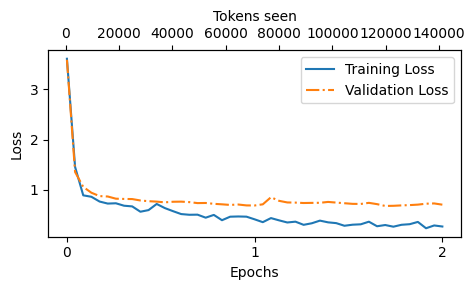

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize = (5,3))
  ax1.plot(epochs_seen, train_losses, label = 'Training Loss')
  ax1.plot(
      epochs_seen, val_losses, linestyle = '-.', label = 'Validation Loss'
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc = 'upper right')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha = 0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

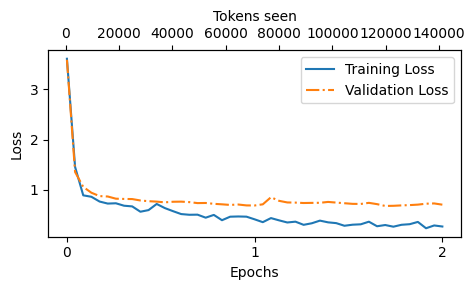

In [43]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7\.3 Valutazione del modello

Generazione degli output rispetto a tutto il dataset di test.

In [44]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total = len(test_data)):
  iput_text = format_input(entry)

  token_ids = generate(
      model,
      text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens=256,
      context_size = BASE_CONFIG['context_length'],
      eos_id = 50256
  )
  generated_text = token_ids_to_text(token_ids, tokenizer)

  response_text = generated_text[len(input_text):].replace("### Response:","").strip()
  test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file: json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:38<00:00,  1.12it/s]


In [57]:
print(test_data[3])

{'instruction': 'What is the periodic symbol for chlorine?', 'input': '', 'output': 'The periodic symbol for chlorine is Cl.', 'model_response': 'The chef prepares the meal every day.\n\n\nFlour, sugar, salt, and heat.'}


Adesso non rimane che salvare i pesi del modello in un file appropriato.

In [47]:
import re
# Remove white spaces and parentheses from file name
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

#The saved model can then be loaded via
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


<All keys matched successfully>

La valutazione delle risposte di un modello come questo a delle istruzioni umane non puo essere puramente numerica. Esistono numerosi metodi che permettono di valutare la performance del modello, alcuni dei quali coinvolgono valutazioni umane dell'output. E anche possibile utilizzare un altro modello piu complesso per valutare le prestazioni di un altro.